<div align = "center">

# **Frecuencia-Severidad**

</div>

## Librerias

In [51]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)

## Data

In [52]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [53]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Grupo_Edad,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>
1,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41-63,2,1834,2558114,10,1279057
2,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,2,1203,4883644,7,2441822
3,1997,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41-63,2,3077,4238816,16,2119408
4,1998,AZUL,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,2,2791,8213167,16,4106584
5,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,2,2410,8014069,13,4007035
6,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,4,4223,6450375,23,1612594


# **Severidad**

## Seleccion de variables

In [54]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Grupo_Edad")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2012 
Variable: Color - Categoría de referencia: PLATA 
Variable: Carroceria - Categoría de referencia: HATCHBACK 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Grupo_Edad - Categoría de referencia: 41-63 
'data.frame':	258 obs. of  13 variables:
 $ Modelo          : Factor w/ 18 levels "2012","1993",..: 2 2 3 4 4 4 4 4 4 5 ...
 $ Color           : Factor w/ 19 levels "PLATA","AMARILLO",..: 16 16 5 3 5 5 9 16 18 5 ...
 $ Carroceria      : Factor w/ 10 levels "HATCHBACK","BUS-BUSETA",..: 8 8 8 8 8 8 10 8 8 8 ...
 $ CLASE_FASECOLDA : Factor w/ 7 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 1 1 5 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        : Factor w/ 3 levels "Particular","Publi

In [55]:
# Modelo completo de severidad
modelo_sev_completo <- glm(
  suma_pagos ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Modelo nulo de severidad
modelo_sev_nulo <- glm(
  suma_pagos ~ 1,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Stepwise
modelo_severidad_final <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "both",
  trace = TRUE
)

Start:  AIC=23111.43
suma_pagos ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad


Step:  AIC=23111.43
suma_pagos ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    SERVICIO + Sexo_Aseg + Grupo_Edad

                  Df Deviance   AIC
- Modelo          17   583.34 23097
- CLASE_FASECOLDA  4   548.06 23108
- Carroceria       7   562.61 23108
- Grupo_Edad       2   541.93 23109
- Color           18   618.66 23111
<none>                 537.73 23111
- SERVICIO         2   550.97 23113
- Sexo_Aseg        1   552.09 23116

Step:  AIC=23140.24
suma_pagos ~ Color + Carroceria + CLASE_FASECOLDA + SERVICIO + 
    Sexo_Aseg + Grupo_Edad



## Evaluacion

Warning message in title(...):
“conversion failure on '√|Residuos Estandarizados|' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on '√|Residuos Estandarizados|' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in title(...):
“conversion failure on '√|Residuos Estandarizados|' in 'mbcsToSbcs': dot substituted for <9a>”


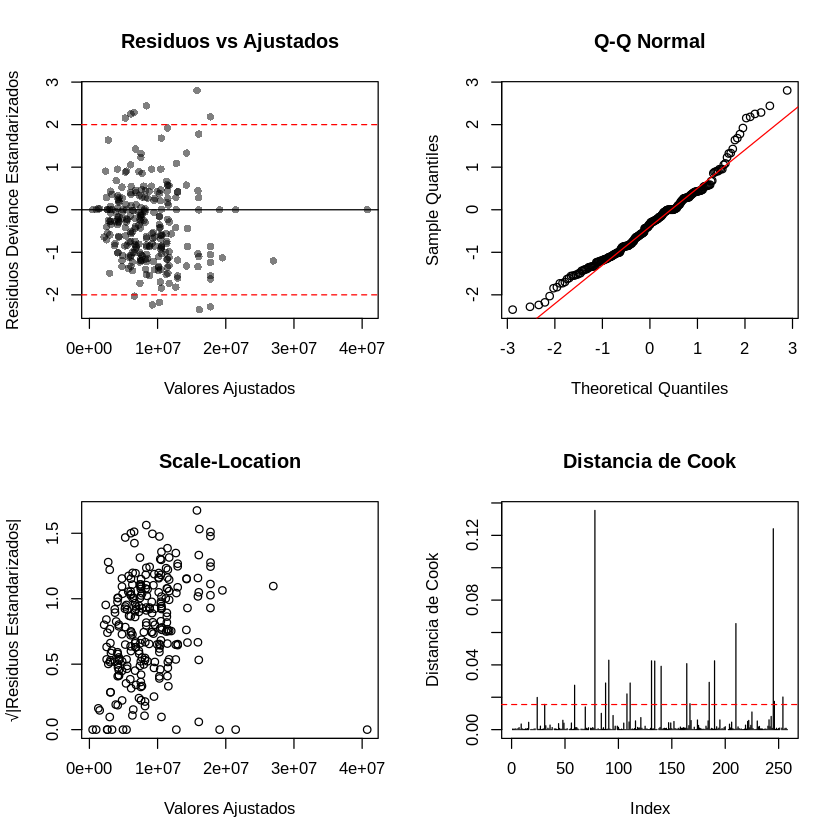

In [56]:
# Calcular residuos deviance estandarizados
residuos_dev <- residuals(modelo_severidad_final, type = "deviance")
residuos_std <- residuos_dev / sqrt(summary(modelo_severidad_final)$dispersion)

# Gráfico de residuos vs valores ajustados
par(mfrow = c(2, 2))

# 1. Residuos vs Fitted
plot(fitted(modelo_severidad_final), residuos_std,
     xlab = "Valores Ajustados", 
     ylab = "Residuos Deviance Estandarizados",
     main = "Residuos vs Ajustados",
     pch = 16, col = rgb(0, 0, 0, 0.5))
abline(h = c(-2, 0, 2), lty = c(2, 1, 2), col = c("red", "black", "red"))

# 2. Q-Q plot
qqnorm(residuos_std, main = "Q-Q Normal")
qqline(residuos_std, col = "red")

# 3. Scale-Location
plot(fitted(modelo_severidad_final), sqrt(abs(residuos_std)),
     xlab = "Valores Ajustados",
     ylab = "√|Residuos Estandarizados|",
     main = "Scale-Location")

# 4. Distancia de Cook
plot(cooks.distance(modelo_severidad_final), 
     type = "h",
     main = "Distancia de Cook",
     ylab = "Distancia de Cook")
abline(h = 4/nrow(data), lty = 2, col = "red")